In [18]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from datasets import load_dataset
import numpy as np

In [19]:
class SketchAnimeDataset(Dataset):
    def __init__(self, sketch_dir, anime_dir, transform=None, img_size=512):
        self.sketch_dir = sketch_dir
        self.anime_dir = anime_dir
        self.transform = transform
        self.img_size = img_size
        
        # Obtener lista de archivos (asumiendo mismos nombres)
        self.sketch_files = sorted([f for f in os.listdir(sketch_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.anime_files = sorted([f for f in os.listdir(anime_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        
        # Verificar que coincidan
        assert len(self.sketch_files) == len(self.anime_files), "Los datasets deben tener el mismo número de imágenes"
        
        # Transformaciones por defecto
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                # Normalizar para 3 canales RGB
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ])
    
    def __len__(self):
        return len(self.sketch_files)
    
    def __getitem__(self, idx):
        sketch_path = os.path.join(self.sketch_dir, self.sketch_files[idx])
        anime_path = os.path.join(self.anime_dir, self.anime_files[idx])
        
        sketch = Image.open(sketch_path).convert('RGB')
        anime = Image.open(anime_path).convert('RGB')
        
        # Aplicar transformaciones
        sketch_tensor = self.transform(sketch)
        anime_tensor = self.transform(anime)
        
        return {
            'sketch': sketch_tensor,
            'anime': anime_tensor,
            'sketch_path': sketch_path,
            'anime_path': anime_path
        }


In [20]:
def prepare_dataset(data_path, batch_size=4, validation_split=0.1):
    """
    Prepara los dataloaders para entrenamiento y validación
    """
    sketch_dir = os.path.join(data_path, 'sketches')
    anime_dir = os.path.join(data_path, 'faces')
    
    dataset = SketchAnimeDataset(sketch_dir, anime_dir)
    
    # Dividir en train/validation
    dataset_size = len(dataset)
    val_size = int(validation_split * dataset_size)
    train_size = dataset_size - val_size
    
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        # num_workers=2,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        # num_workers=2,
        pin_memory=True
    )
    
    return train_loader, val_loader

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_dataset_samples(dataloader, num_samples=4):
    """
    Visualiza pares (sketch, anime) desde un dataloader.
    Maneja batches más pequeños que num_samples para evitar IndexError.
    """
    batch = next(iter(dataloader))
    sketches = batch['sketch']
    animes = batch['anime']

    batch_size = sketches.size(0)
    samples = min(num_samples, batch_size)
    if samples == 0:
        print("No hay muestras en el batch.")
        return

    fig, axes = plt.subplots(2, samples, figsize=(4 * samples, 6))

    # Asegurar que axes tenga forma (2, samples)
    axes = np.array(axes)
    if axes.ndim == 1:
        axes = axes[:, np.newaxis]

    for i in range(samples):
        # Sketch
        sketch = sketches[i].permute(1, 2, 0).cpu().numpy()
        sketch = (sketch * 0.5 + 0.5)  # Desnormalizar
        axes[0, i].imshow(np.clip(sketch, 0, 1))
        axes[0, i].set_title(f'Sketch {i+1}')
        axes[0, i].axis('off')

        # Anime
        anime = animes[i].permute(1, 2, 0).cpu().numpy()
        anime = (anime * 0.5 + 0.5)  # Desnormalizar
        axes[1, i].imshow(np.clip(anime, 0, 1))
        axes[1, i].set_title(f'Anime {i+1}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
import torch
from torch.optim import AdamW
from diffusers import (
    ControlNetModel, 
    StableDiffusionControlNetPipeline,
    DDPMScheduler,
    AutoencoderKL,
    UNet2DConditionModel
)
from peft import LoraConfig, get_peft_model
from tqdm.auto import tqdm
import torch.nn.functional as F
from transformers import AutoTokenizer, CLIPTextModel
from PIL import Image

class SketchToAnimeControlNetLoRA:
    def __init__(self, model_name="runwayml/stable-diffusion-v1-5", device="cuda"):
        self.device = device
        self.model_name = model_name
        
        # Usar float32 consistentemente para evitar problemas de dtype
        self.dtype = torch.float32
        
        # Cargar ControlNet pre-entrenado para sketches
        print("Cargando ControlNet...")
        self.controlnet = ControlNetModel.from_pretrained(
            "lllyasviel/sd-controlnet-scribble",
            torch_dtype=self.dtype
        )
        
        # Cargar otros componentes
        print("Cargando VAE...")
        self.vae = AutoencoderKL.from_pretrained(
            model_name, 
            subfolder="vae",
            torch_dtype=self.dtype
        )
        
        print("Cargando tokenizer y text encoder...")
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name, 
            subfolder="tokenizer"
        )
        
        self.text_encoder = CLIPTextModel.from_pretrained(
            model_name, 
            subfolder="text_encoder",
            torch_dtype=self.dtype
        )
        
        print("Cargando scheduler...")
        self.scheduler = DDPMScheduler.from_pretrained(
            model_name, 
            subfolder="scheduler"
        )
        
        # Mover a GPU
        self.vae = self.vae.to(device, dtype=self.dtype)
        self.controlnet = self.controlnet.to(device, dtype=self.dtype)
        self.text_encoder = self.text_encoder.to(device, dtype=self.dtype)
        
        # Congelar VAE y text encoder
        self.vae.requires_grad_(False)
        self.text_encoder.requires_grad_(False)
        
        # Configurar LoRA para ControlNet
        self.setup_lora()
        
        print("Modelo inicializado correctamente")
    
    def setup_lora(self, r=16, lora_alpha=32, lora_dropout=0.1):
        """Configura LoRA para el ControlNet"""
        print("Configurando LoRA...")
        lora_config = LoraConfig(
            r=r,
            lora_alpha=lora_alpha,
            target_modules=["to_k", "to_q", "to_v", "to_out.0"],
            lora_dropout=lora_dropout,
        )
        
        self.controlnet = get_peft_model(self.controlnet, lora_config)
        self.controlnet.print_trainable_parameters()
    
    def encode_text(self, prompts):
        """Codificar textos"""
        inputs = self.tokenizer(
            prompts, 
            padding="max_length", 
            max_length=77, 
            truncation=True, 
            return_tensors="pt"
        )
        
        with torch.no_grad():
            text_embeddings = self.text_encoder(
                inputs.input_ids.to(self.device, dtype=torch.long)
            )[0]
        
        return text_embeddings
    
    def prepare_images(self, images):
        """Preparar imágenes para el modelo"""
        # Las imágenes ya deberían estar normalizadas por el DataLoader
        # pero nos aseguramos de que estén en el rango correcto
        return images.to(self.device, dtype=self.dtype)
    
    def train(self, train_loader, val_loader, epochs=100, lr=1e-4):
        """Entrenamiento del modelo"""
        optimizer = AdamW(self.controlnet.parameters(), lr=lr)
        
        global_step = 0
        for epoch in range(epochs):
            self.controlnet.train()
            train_loss = 0.0
            num_batches = 0
            
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
            
            for batch in progress_bar:
                # Obtener batches y asegurar dtype consistente
                sketches = self.prepare_images(batch['sketch'])
                animes = self.prepare_images(batch['anime'])
                
                # Usar prompts genéricos
                prompts = ["anime style, high quality, detailed"] * sketches.size(0)
                text_embeddings = self.encode_text(prompts)
                
                # Codificar imágenes con VAE
                with torch.no_grad():
                    # Preparar condition image (sketch) - asegurar mismo tamaño
                    if sketches.shape[-2:] != (512, 512):
                        sketches = F.interpolate(sketches, size=(512, 512), mode='bilinear')
                    condition_images = sketches
                    
                    # Target image (anime)
                    if animes.shape[-2:] != (512, 512):
                        animes = F.interpolate(animes, size=(512, 512), mode='bilinear')
                    
                    anime_latents = self.vae.encode(animes).latent_dist.sample()
                    anime_latents = anime_latents * 0.18215
                
                # Samplear noise
                noise = torch.randn_like(anime_latents, dtype=self.dtype)
                timesteps = torch.randint(
                    0, self.scheduler.config.num_train_timesteps, 
                    (anime_latents.shape[0],), 
                    device=self.device
                ).long()
                
                # Add noise
                noisy_latents = self.scheduler.add_noise(anime_latents, noise, timesteps)
                
                # Predicción con ControlNet
                # ControlNet espera: sample, timestep, encoder_hidden_states, controlnet_cond
                down_block_res_samples, mid_block_res_sample = self.controlnet(
                    sample=noisy_latents,
                    timestep=timesteps,
                    encoder_hidden_states=text_embeddings,
                    controlnet_cond=condition_images,
                    return_dict=False,
                )
                
                # Para training simple, usamos una aproximación
                # En realidad necesitaríamos el UNet completo, pero para fine-tuning
                # nos enfocamos en que el ControlNet aprenda las características
                noise_pred = down_block_res_samples[0]  # Usamos el primer bloque como aproximación
                
                # Asegurar que las dimensiones coincidan
                if noise_pred.shape != noise.shape:
                    noise_pred = F.interpolate(noise_pred, size=noise.shape[-2:], mode='nearest')
                
                # Loss
                loss = F.mse_loss(noise_pred, noise)
                
                # Backward
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.controlnet.parameters(), 1.0)
                optimizer.step()
                
                train_loss += loss.item()
                num_batches += 1
                global_step += 1
                
                progress_bar.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "avg_loss": f"{train_loss/num_batches:.4f}"
                })
                
                # Limpiar memoria
                if global_step % 10 == 0:
                    torch.cuda.empty_cache()
            
            avg_train_loss = train_loss / num_batches if num_batches > 0 else 0
            
            # Validación cada 5 épocas
            if (epoch + 1) % 5 == 0:
                val_loss = self.validate(val_loader)
                print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
                
                # Guardar checkpoint
                self.save_checkpoint(epoch, optimizer, f"checkpoint_epoch_{epoch+1}")
            else:
                print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}")
    
    def validate(self, val_loader):
        """Validación del modelo"""
        self.controlnet.eval()
        val_loss = 0.0
        num_batches = 0
        
        with torch.no_grad():
            for batch in val_loader:
                sketches = self.prepare_images(batch['sketch'])
                animes = self.prepare_images(batch['anime'])
                
                prompts = ["anime style, high quality, detailed"] * sketches.size(0)
                text_embeddings = self.encode_text(prompts)
                
                # Codificar
                if sketches.shape[-2:] != (512, 512):
                    sketches = F.interpolate(sketches, size=(512, 512), mode='bilinear')
                condition_images = sketches
                
                if animes.shape[-2:] != (512, 512):
                    animes = F.interpolate(animes, size=(512, 512), mode='bilinear')
                
                anime_latents = self.vae.encode(animes).latent_dist.sample()
                anime_latents = anime_latents * 0.18215
                
                noise = torch.randn_like(anime_latents, dtype=self.dtype)
                timesteps = torch.randint(
                    0, self.scheduler.config.num_train_timesteps, 
                    (anime_latents.shape[0],), 
                    device=self.device
                ).long()
                
                noisy_latents = self.scheduler.add_noise(anime_latents, noise, timesteps)
                
                down_block_res_samples, mid_block_res_sample = self.controlnet(
                    sample=noisy_latents,
                    timestep=timesteps,
                    encoder_hidden_states=text_embeddings,
                    controlnet_cond=condition_images,
                    return_dict=False,
                )
                
                noise_pred = down_block_res_samples[0]
                if noise_pred.shape != noise.shape:
                    noise_pred = F.interpolate(noise_pred, size=noise.shape[-2:], mode='nearest')
                
                loss = F.mse_loss(noise_pred, noise)
                val_loss += loss.item()
                num_batches += 1
        
        return val_loss / num_batches if num_batches > 0 else 0
    
    def save_checkpoint(self, epoch, optimizer, filename):
        """Guardar checkpoint del modelo"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.controlnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lora_config': self.controlnet.peft_config
        }
        
        torch.save(checkpoint, f"{filename}.pth")
        print(f"Checkpoint guardado: {filename}.pth")
    
    def load_checkpoint(self, checkpoint_path, optimizer=None):
        """Cargar checkpoint"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        
        self.controlnet.load_state_dict(checkpoint['model_state_dict'])
        
        if optimizer is not None:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        print(f"Checkpoint cargado: {checkpoint_path}")
        return checkpoint['epoch']


# Clase para inferencia después del entrenamiento
class SketchToAnimeInference:
    def __init__(self, checkpoint_path, base_model="runwayml/stable-diffusion-v1-5", device="cuda"):
        self.device = device
        
        # Cargar pipeline completo con ControlNet
        self.controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-scribble")
        
        self.pipeline = StableDiffusionControlNetPipeline.from_pretrained(
            base_model,
            controlnet=self.controlnet,
            safety_checker=None,
            requires_safety_checker=False,
            torch_dtype=torch.float32
        )
        
        # Cargar weights de LoRA
        checkpoint = torch.load(checkpoint_path, map_location=device)
        self.pipeline.controlnet.load_state_dict(checkpoint['model_state_dict'])
        
        self.pipeline = self.pipeline.to(device)
        
    def convert_sketch_to_anime(self, sketch_image, prompt="anime style, high quality, detailed", 
                               num_inference_steps=20, guidance_scale=7.5):
        """
        Convierte un sketch a estilo anime
        """
        # Preprocesar imagen
        if sketch_image.size != (512, 512):
            sketch_image = sketch_image.resize((512, 512), Image.LANCZOS)
        
        # Generar imagen
        result = self.pipeline(
            prompt=prompt,
            image=sketch_image,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=torch.Generator(device=self.device).manual_seed(42)
        )
        
        return result.images[0]

Usando dispositivo: cuda
Preparando datasets...
Visualizando ejemplos del dataset...


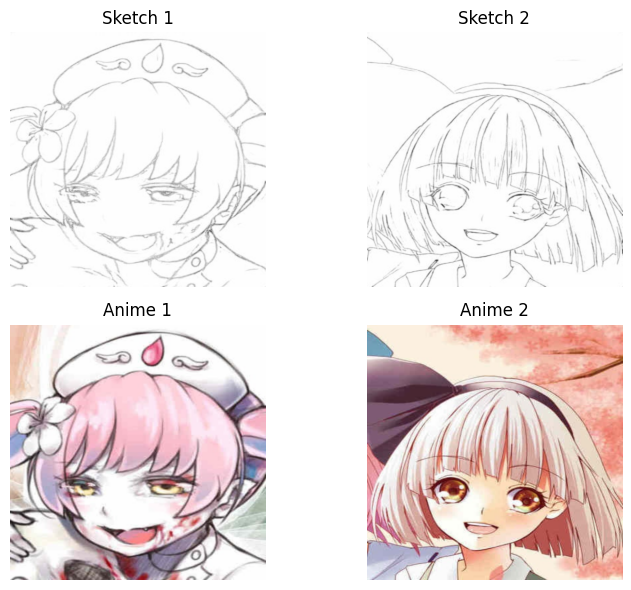

In [23]:
# Configuración
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")

# Rutas de dataset
data_path = r"D:\Ciencias\Drawnime\data\train"  # Cambiar por tu ruta
batch_size = 2  # Reducir batch size por memoria

# Preparar datasets
print("Preparando datasets...")
train_loader, val_loader = prepare_dataset(data_path, batch_size=batch_size)

# Visualizar algunos ejemplos
print("Visualizando ejemplos del dataset...")
visualize_dataset_samples(train_loader)

In [29]:
# Inicializar modelo
print("Inicializando modelo...")
model = SketchToAnimeControlNetLoRA(device=device)

Inicializando modelo...
Cargando ControlNet...
Cargando VAE...
Cargando VAE...
Cargando tokenizer y text encoder...
Cargando tokenizer y text encoder...


`torch_dtype` is deprecated! Use `dtype` instead!


Cargando scheduler...
Configurando LoRA...
trainable params: 1,462,272 || all params: 362,741,392 || trainable%: 0.4031
Modelo inicializado correctamente
Configurando LoRA...
trainable params: 1,462,272 || all params: 362,741,392 || trainable%: 0.4031
Modelo inicializado correctamente


In [30]:
# Entrenar
print("Comenzando entrenamiento...")
model.train(train_loader, val_loader, epochs=50, lr=1e-4)

Comenzando entrenamiento...


Epoch 1/50:   0%|          | 0/4541 [00:00<?, ?it/s]C:\Users\Animetx\AppData\Local\Temp\ipykernel_8436\2559762848.py:173: UserWarning: Using a target size (torch.Size([2, 4, 64, 64])) that is different to the input size (torch.Size([2, 320, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(noise_pred, noise)
Epoch 1/50:   0%|          | 0/4541 [00:13<?, ?it/s]C:\Users\Animetx\AppData\Local\Temp\ipykernel_8436\2559762848.py:173: UserWarning: Using a target size (torch.Size([2, 4, 64, 64])) that is different to the input size (torch.Size([2, 320, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(noise_pred, noise)
Epoch 1/50:   0%|          | 0/4541 [00:13<?, ?it/s]



RuntimeError: The size of tensor a (320) must match the size of tensor b (4) at non-singleton dimension 1